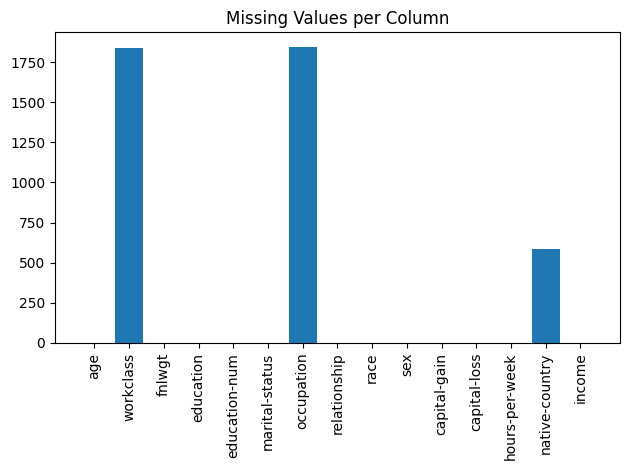

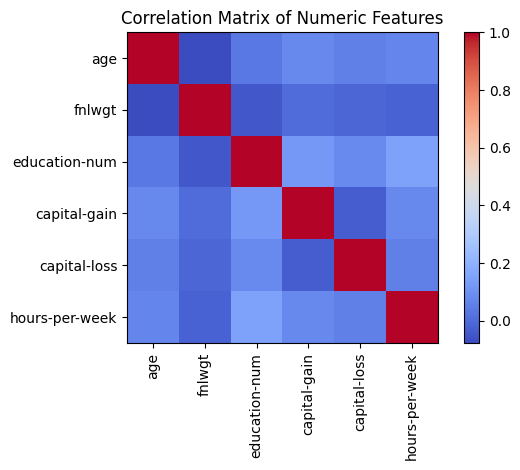

<ipython-input-1-6e9ded22ee41>:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([group1, group2], labels=["<=50K", ">50K"])


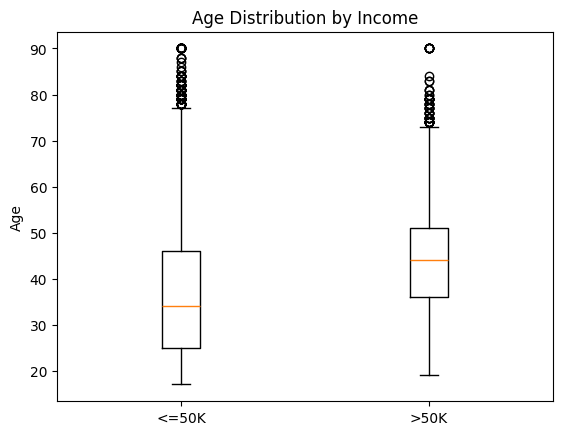

In [1]:
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data -O adult.data

import numpy as np
import matplotlib.pyplot as plt

col_names = np.array(["age", "workclass", "fnlwgt", "education", "education-num",
                      "marital-status", "occupation", "relationship", "race", "sex",
                      "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"])

data = np.genfromtxt("adult.data", delimiter=",", dtype=str, autostrip=True)

cols = {}
for i, col in enumerate(col_names):
    cols[col] = data[:, i]

num_features = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]
cat_features = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]
target_feature = "income"

for col in num_features:
    cols[col] = np.array([float(x) if x != '?' else np.nan for x in cols[col]])

for col in cat_features + [target_feature]:
    cols[col] = np.array(cols[col])

missing_counts = {}
for idx, key in enumerate(col_names):
    missing_counts[key] = np.sum(data[:, idx] == '?')

plt.figure()
plt.bar(list(missing_counts.keys()), list(missing_counts.values()))
plt.xticks(rotation=90)
plt.title("Missing Values per Column")
plt.tight_layout()
plt.show()

num_matrix = np.column_stack([cols[col] for col in num_features])
def nan_mean(x):
    return np.nanmean(x)
num_matrix_filled = np.column_stack([np.where(np.isnan(c), nan_mean(c), c) for c in [cols[col] for col in num_features]])
corr_matrix = np.corrcoef(num_matrix_filled.T)

plt.figure()
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(num_features)), num_features, rotation=90)
plt.yticks(range(len(num_features)), num_features)
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.show()

income_vals = cols[target_feature]
age_vals = cols["age"]
group1 = age_vals[income_vals == "<=50K"]
group2 = age_vals[income_vals == ">50K"]

plt.figure()
plt.boxplot([group1, group2], labels=["<=50K", ">50K"])
plt.title("Age Distribution by Income")
plt.ylabel("Age")
plt.show()


In [2]:
import numpy as np

def linear_regression_impute_numeric(data_matrix, col_idx, predictor_indices):
    X = data_matrix[:, predictor_indices]
    y = data_matrix[:, col_idx]
    valid_rows = ~np.isnan(y) & np.all(~np.isnan(X), axis=1)
    if np.sum(valid_rows) == 0:
        return data_matrix
    X_train = X[valid_rows]
    y_train = y[valid_rows]
    X_train_int = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
    coeff, _, _, _ = np.linalg.lstsq(X_train_int, y_train, rcond=None)
    missing_rows = np.isnan(y) & np.all(~np.isnan(X), axis=1)
    if np.sum(missing_rows) > 0:
        X_missing = X[missing_rows]
        X_missing_int = np.hstack([np.ones((X_missing.shape[0], 1)), X_missing])
        y_pred = X_missing_int.dot(coeff)
        data_matrix[missing_rows, col_idx] = y_pred
    return data_matrix


def mean_impute_numeric(data_matrix, col_idx):
    col = data_matrix[:, col_idx]
    mean_val = np.nanmean(col)
    col[np.isnan(col)] = mean_val
    data_matrix[:, col_idx] = col
    return data_matrix


def mode_impute_categorical(cat_array):
    valid = cat_array[cat_array != '?']
    if valid.size == 0:
        return cat_array
    uniq, counts = np.unique(valid, return_counts=True)
    mode_val = uniq[np.argmax(counts)]
    cat_array[cat_array == '?'] = mode_val
    return cat_array


def log_scale_numeric(data_matrix):
    return np.log1p(data_matrix)


def robust_scale_numeric(data_matrix):
    med = np.median(data_matrix, axis=0)
    q1 = np.percentile(data_matrix, 25, axis=0)
    q3 = np.percentile(data_matrix, 75, axis=0)
    iqr = q3 - q1
    scaled = (data_matrix - med) / iqr
    return scaled


def label_encode(cat_array):
    uniq = np.unique(cat_array)
    mapping = {val: i for i, val in enumerate(uniq)}
    encoded = np.array([mapping[val] for val in cat_array])
    return encoded


num_indices = [i for i, col in enumerate(col_names) if col in num_features]
cat_indices = [i for i, col in enumerate(col_names) if col in cat_features]
target_index = np.where(col_names == target_feature)[0][0]

numeric_data = np.column_stack([cols[col] for col in num_features])
numeric_data = numeric_data.astype(float)

numeric_data_lr = numeric_data.copy()
numeric_data_mean = numeric_data.copy()

for i in range(numeric_data_lr.shape[1]):
    if np.any(np.isnan(numeric_data_lr[:, i])):
        predictors = [j for j in range(numeric_data_lr.shape[1]) if j != i]
        numeric_data_lr = linear_regression_impute_numeric(numeric_data_lr, i, predictors)


for i in range(numeric_data_mean.shape[1]):
    numeric_data_mean = mean_impute_numeric(numeric_data_mean, i)


categorical_data = []
for col in cat_features:
    cat_col = cols[col].copy()
    cat_col = mode_impute_categorical(cat_col)
    categorical_data.append(cat_col)
categorical_data = np.column_stack(categorical_data)

target_data = cols[target_feature].copy()

numeric_lr_log = log_scale_numeric(numeric_data_lr)
numeric_lr_robust = robust_scale_numeric(numeric_data_lr)
numeric_mean_log = log_scale_numeric(numeric_data_mean)
numeric_mean_robust = robust_scale_numeric(numeric_data_mean)


def process_pipeline(numeric_matrix, categorical_matrix, target_array):
    num_processed = numeric_matrix
    cat_processed = np.empty(categorical_matrix.shape)
    for j in range(categorical_matrix.shape[1]):
        cat_processed[:, j] = label_encode(categorical_matrix[:, j])
    target_encoded = label_encode(target_array)
    combined = np.hstack([num_processed, cat_processed.astype(float)])
    return combined, target_encoded


P1_X, P1_y = process_pipeline(numeric_lr_log, categorical_data, target_data)
P2_X, P2_y = process_pipeline(numeric_lr_robust, categorical_data, target_data)
P3_X, P3_y = process_pipeline(numeric_mean_log, categorical_data, target_data)
P4_X, P4_y = process_pipeline(numeric_mean_robust, categorical_data, target_data)


<ipython-input-2-dfbb0bd36dcb>:49: RuntimeWarning: divide by zero encountered in divide
  scaled = (data_matrix - med) / iqr
<ipython-input-2-dfbb0bd36dcb>:49: RuntimeWarning: invalid value encountered in divide
  scaled = (data_matrix - med) / iqr


In [3]:
import numpy as np

def add_intercept(X):
    intercept = np.ones((X.shape[0], 1))
    return np.hstack([intercept, X])


def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def logistic_regression_train(X, y, lr=0.1, num_iter=2000, reg='l1', lambda_reg=0.01):
    n, d = X.shape
    theta = np.zeros(d)
    for i in range(num_iter):
        z = X.dot(theta)
        h = sigmoid(z)
        error = h - y
        grad = (X.T.dot(error)) / n
        if reg == 'l1':
            grad += lambda_reg * np.sign(theta)
        elif reg == 'l2':
            grad += lambda_reg * theta
        theta = theta - lr * grad
    return theta


def logistic_regression_predict(X, theta):
    probs = sigmoid(X.dot(theta))
    return (probs >= 0.5).astype(int)


def svm_train(X, y, lr=0.01, num_iter=2000, reg='l1', lambda_reg=0.01):
    n, d = X.shape
    theta = np.zeros(d)
    y_trans = 2 * y - 1
    for i in range(num_iter):
        margins = y_trans * (X.dot(theta))
        grad = np.zeros(d)
        for j in range(n):
            if margins[j] < 1:
                grad += -y_trans[j] * X[j]
        grad = grad / n
        if reg == 'l1':
            grad += lambda_reg * np.sign(theta)
        elif reg == 'l2':
            grad += lambda_reg * theta
        theta = theta - lr * grad
    return theta


def svm_predict(X, theta):
    scores = X.dot(theta)
    return (scores >= 0).astype(int)


def train_test_split(X, y, test_size=0.2, random_state=42):
    np.random.seed(random_state)
    indices = np.random.permutation(X.shape[0])
    test_count = int(test_size * X.shape[0])
    test_idx = indices[:test_count]
    train_idx = indices[test_count:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]


def compute_metrics(y_true, y_pred):
    accuracy = np.mean(y_true == y_pred)
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    cm = np.array([[tn, fp], [fn, tp]])
    return accuracy, precision, recall, f1, cm


pipelines = {"P1": (P1_X, P1_y), "P2": (P2_X, P2_y), "P3": (P3_X, P3_y), "P4": (P4_X, P4_y)}
results = {}

for key, (X_data, y_data) in pipelines.items():

    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

    X_train_int = add_intercept(X_train)
    X_test_int = add_intercept(X_test)

    results[key] = {}

    if key in ["P1", "P2"]:
        reg_type = 'l1'
    else:
        reg_type = 'l2'


    theta_lr = logistic_regression_train(X_train_int, y_train, lr=0.1, num_iter=2000, reg=reg_type, lambda_reg=0.01)
    pred_lr = logistic_regression_predict(X_test_int, theta_lr)
    acc, prec, rec, f1, cm = compute_metrics(y_test, pred_lr)
    results[key]['LogisticRegression'] = {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1_score': f1, 'confusion_matrix': cm}


    theta_svm = svm_train(X_train_int, y_train, lr=0.01, num_iter=2000, reg=reg_type, lambda_reg=0.01)
    pred_svm = svm_predict(X_test_int, theta_svm)
    acc, prec, rec, f1, cm = compute_metrics(y_test, pred_svm)
    results[key]['SVM'] = {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1_score': f1, 'confusion_matrix': cm}


print("Model Evaluation Results:")

for pipeline in results:

    print("\nPipeline:", pipeline)

    for model in results[pipeline]:

        print(" Model:", model)
        print("  Accuracy:", results[pipeline][model]['accuracy'])
        print("  Precision:", results[pipeline][model]['precision'])
        print("  Recall:", results[pipeline][model]['recall'])
        print("  F1 Score:", results[pipeline][model]['f1_score'])
        print("  Confusion Matrix:\n", results[pipeline][model]['confusion_matrix'])
        print("")


Model Evaluation Results:

Pipeline: P1
 Model: LogisticRegression
  Accuracy: 0.6845823095823096
  Precision: 0.42360012654223345
  Recall: 0.8523233609166136
  F1 Score: 0.5659340659340658
  Confusion Matrix:
 [[3119 1822]
 [ 232 1339]]

 Model: SVM
  Accuracy: 0.7605958230958231
  Precision: 0.7727272727272727
  Recall: 0.010821133036282623
  F1 Score: 0.021343377275580666
  Confusion Matrix:
 [[4936    5]
 [1554   17]]


Pipeline: P2
 Model: LogisticRegression
  Accuracy: 0.7587530712530712
  Precision: 0
  Recall: 0.0
  F1 Score: 0
  Confusion Matrix:
 [[4941    0]
 [1571    0]]

 Model: SVM
  Accuracy: 0.7587530712530712
  Precision: 0
  Recall: 0.0
  F1 Score: 0
  Confusion Matrix:
 [[4941    0]
 [1571    0]]


Pipeline: P3
 Model: LogisticRegression
  Accuracy: 0.7601351351351351
  Precision: 0.68
  Recall: 0.010821133036282623
  F1 Score: 0.021303258145363407
  Confusion Matrix:
 [[4933    8]
 [1554   17]]

 Model: SVM
  Accuracy: 0.7936117936117936
  Precision: 0.649933949801

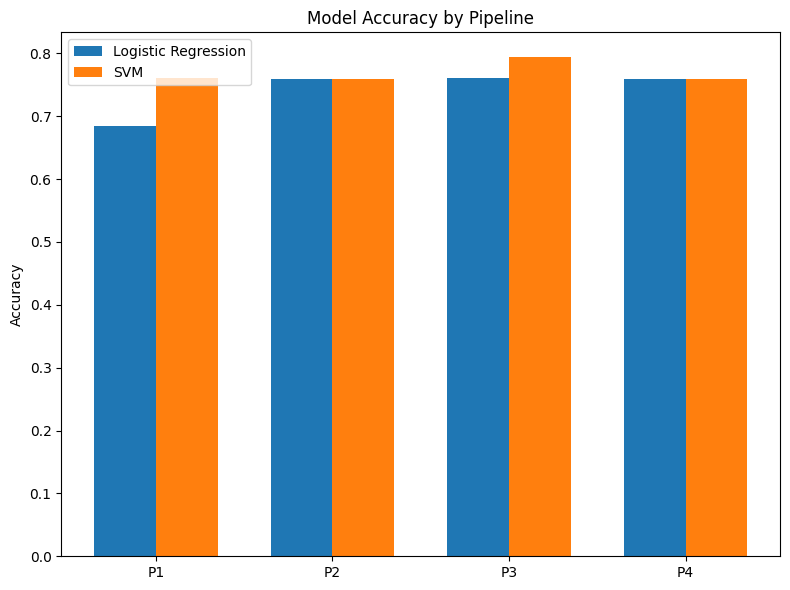

In [4]:
import numpy as np
import matplotlib.pyplot as plt

pipelines_list = []
lr_accuracy = []
svm_accuracy = []

for pipeline in results:

    pipelines_list.append(pipeline)
    lr_accuracy.append(results[pipeline]['LogisticRegression']['accuracy'])
    svm_accuracy.append(results[pipeline]['SVM']['accuracy'])

x = np.arange(len(pipelines_list))
width = 0.35

plt.figure(figsize=(8,6))
plt.bar(x - width/2, lr_accuracy, width, label='Logistic Regression')
plt.bar(x + width/2, svm_accuracy, width, label='SVM')
plt.ylabel('Accuracy')
plt.xticks(x, pipelines_list)
plt.title('Model Accuracy by Pipeline')
plt.legend()
plt.tight_layout()
plt.show()
